In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.cluster import AgglomerativeClustering

data = pd.read_csv('../data/data_collection_202203_202308.csv')

/tmp/ipykernel_40876/747090631.py:8: DtypeWarning: Columns (90,95,97,98,100,103,107,108,110,177,182,184,185,187,190,194,195,197,241,242,243,247,248,251,252,253,257,258,507,726,727,728,729,732,734,735,736,737,739,740,742,743,744,745,747,748,750,751,752,753,756,758,759,760,761,763,764,766,767,768,769,771,772,775,780,782,783,785,788,792,793,795) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/data_collection_202203_202308.csv')


In [2]:
def clean_dataset(data, target_column):
    original_shape = data.shape
    
    # Remove constant features (zero variance)
    constant_features = [col for col in data.columns if col != target_column and data[col].nunique() == 1]
    data = data.drop(columns=constant_features)
    print(f"Removed {len(constant_features)} constant features")
    
    # Handle missing values (choose strategy based on your domain)
    high_null_features = [col for col in data.columns if data[col].isnull().mean() > 0.97]
    data = data.drop(columns=high_null_features)
    print(f"Removed {len(high_null_features)} features with >97% nulls")
    
    # Fill remaining nulls with appropriate values
    numeric_cols = data.select_dtypes(include=['number']).columns
    data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())
    
    print(f"Data shape: {original_shape} → {data.shape}")
    return data

In [3]:
def group_by_prefix(df, target_column):
    # Extract all feature columns (exclude target)
    features = [col for col in df.columns if col != target_column]
    
    # Group by prefix (adjust regex pattern to match your naming convention)
    import re
    prefixes = {}
    for feature in features:
        # Assuming format like QTD_H123 where QTD_ is the prefix
        match = re.match(r'([A-Z]+_[A-Z])', feature)
        if match:
            prefix = match.group(1)
            if prefix not in prefixes:
                prefixes[prefix] = []
            prefixes[prefix].append(feature)
    
    # Filter groups to include only those with multiple features
    prefix_groups = {prefix: cols for prefix, cols in prefixes.items() if len(cols) > 1}
    print(f"Identified {len(prefix_groups)} potential feature groups")
    
    return prefix_groups

In [28]:
# Change min_correlation 0.01 /0.02 0.03 to test
def analyze_target_correlations(df, target_column, min_correlation=0.02):
    from scipy.stats import pointbiserialr, pearsonr
    
    # Dictionary to store results
    feature_correlations = {}
    
    # Choose correlation method based on target type
    is_binary_target = df[target_column].nunique() == 2
    
    # Calculate correlation for each feature
    for col in [c for c in df.columns if c != target_column]:
        try:
            if is_binary_target:
                corr, p_value = pointbiserialr(df[target_column], df[col])
            else:
                corr, p_value = pearsonr(df[target_column], df[col])
                
            feature_correlations[col] = {
                'correlation': corr,
                'p_value': p_value,
                'significant': p_value < 0.05 and abs(corr) >= min_correlation
            }
        except:
            # Handle error cases (e.g., constant values)
            feature_correlations[col] = {
                'correlation': 0,
                'p_value': 1,
                'significant': False
            }
    
    # Convert to DataFrame
    corr_df = pd.DataFrame.from_dict(feature_correlations, orient='index')
    
    # Filter to significant correlations
    significant_features = corr_df[corr_df['significant']].sort_values('correlation', ascending=False)
    print(f"Found {len(significant_features)} features with significant correlation to target")
    
    return corr_df, significant_features

In [29]:
def analyze_and_aggregate_groups(df, groups, target_correlations, target_column):
    import numpy as np
    import pandas as pd

    aggregated_features = {}
    group_analysis = {}
    new_aggregates = {}  # Temporary storage for new aggregate columns

    for group_name, features in groups.items():
        # Filter out features with significant correlation to the target
        sig_features = [f for f in features 
                        if f in target_correlations.index and 
                           target_correlations.loc[f, 'significant']]
        
        if len(sig_features) <= 1:
            print(f"Group {group_name}: Insufficient significant features, skipping")
            continue

        # Compute inter-feature correlation
        inter_corr = df[sig_features].corr()
        avg_corr = (inter_corr.sum().sum() - len(sig_features)) / (len(sig_features) * (len(sig_features) - 1))
        
        is_coherent = avg_corr >= 0.3  # Threshold for coherence

        group_analysis[group_name] = {
            'features': sig_features,
            'avg_inter_correlation': avg_corr,
            'is_coherent': is_coherent
        }

        if is_coherent:
            # Calculate correlation weights
            weights = np.abs([target_correlations.loc[f, 'correlation'] for f in sig_features])
            weights = weights / weights.sum()

            # Create aggregate feature without inserting into df directly
            agg_column = sum(df[feat] * weight for feat, weight in zip(sig_features, weights))
            agg_name = f'{group_name}_agg'
            new_aggregates[agg_name] = agg_column

            aggregated_features[group_name] = agg_name
            print(f"Created weighted aggregate for {group_name} with {len(sig_features)} features")

    # Concatenate new aggregate columns to the original DataFrame in one go
    if new_aggregates:
        df = pd.concat([df, pd.DataFrame(new_aggregates)], axis=1)
    return df, aggregated_features, group_analysis


In [30]:
def evaluate_aggregates(df, aggregated_features, target_correlations, group_analysis, target_column):
    from scipy.stats import pointbiserialr, pearsonr
    
    # Choose correlation method based on target type
    is_binary_target = df[target_column].nunique() == 2
    
    # Evaluate performance of aggregated features
    agg_performance = {}
    
    for group_name, agg_feature in aggregated_features.items():
        # Calculate correlation with target
        if is_binary_target:
            corr, p_value = pointbiserialr(df[target_column], df[agg_feature])
        else:
            corr, p_value = pearsonr(df[target_column], df[agg_feature])
            
        # Get best original feature correlation from this group
        original_features = [f for f in group_analysis[group_name]['features']]
        max_orig_corr = max([abs(target_correlations.loc[f, 'correlation']) for f in original_features])
        
        # Calculate retention of signal
        retention = (abs(corr) / max_orig_corr) * 100 if max_orig_corr > 0 else 0
        
        agg_performance[agg_feature] = {
            'correlation': corr,
            'p_value': p_value,
            'signal_retention': retention,
            'improved': abs(corr) > max_orig_corr,
            'effective': retention >= 80
        }
    
    # Convert to DataFrame
    perf_df = pd.DataFrame.from_dict(agg_performance, orient='index')
    
    return perf_df

In [31]:
def automated_feature_aggregation(df, target_column, min_correlation=0.05):
    """
    End-to-end pipeline for automatic feature aggregation
    """
    # 1. Clean dataset
    df_clean = clean_dataset(df.copy(), target_column)
    
    # 2. Group features by naming convention
    feature_groups = group_by_prefix(df_clean, target_column)
    
    # 3. Analyze target correlations
    target_corr_all, sig_features = analyze_target_correlations(
        df_clean, target_column, min_correlation)
    
    # 4. Analyze and create aggregated features
    df_with_agg, agg_features, group_analysis = analyze_and_aggregate_groups(
        df_clean, feature_groups, target_corr_all, target_column)
    
    # 5. Evaluate new features
    agg_performance = evaluate_aggregates(
        df_with_agg, agg_features, target_corr_all, group_analysis, target_column)
    
    # 6. Create final feature set (original significant + effective aggregates)
    effective_aggs = [feat for feat, perf in agg_performance.iterrows() 
                     if perf['effective']]
    
    groups_to_replace = [group for group, feat in agg_features.items() 
                        if feat in effective_aggs]
    
    # Get features to keep (significant features not in aggregated groups)
    features_to_keep = [f for f in sig_features.index 
                      if not any(f in group_analysis[g]['features'] for g in groups_to_replace)]
    
    # Final feature set
    final_features = features_to_keep + effective_aggs
    
    print(f"Final feature set: {len(features_to_keep)} original + {len(effective_aggs)} aggregated = {len(final_features)} total")
    
    return {
        'final_dataframe': df_with_agg[final_features + [target_column]],
        'feature_groups': group_analysis,
        'aggregate_performance': agg_performance,
        'target_correlations': target_corr_all,
        'significant_features': sig_features
    }

In [32]:
# Run the entire pipeline
results = automated_feature_aggregation(data, 'TARGET', min_correlation=0.02)

Removed 61 constant features
Removed 199 features with >97% nulls
Data shape: (299105, 833) → (299105, 573)
Identified 26 potential feature groups
Found 22 features with significant correlation to target
Group COD_E: Insufficient significant features, skipping
Group DSC_F: Insufficient significant features, skipping
Group QTD_F: Insufficient significant features, skipping
Group DSC_L: Insufficient significant features, skipping
Group VAL_L: Insufficient significant features, skipping
Group TAX_L: Insufficient significant features, skipping
Group PCT_L: Insufficient significant features, skipping
Group VAL_H: Insufficient significant features, skipping
Group DSC_H: Insufficient significant features, skipping
Group FLG_N: Insufficient significant features, skipping
Group FLG_H: Insufficient significant features, skipping
Created weighted aggregate for QTD_M with 3 features
Created weighted aggregate for QTD_J with 4 features
Group QT_H: Insufficient significant features, skipping
Group I

In [33]:
final_df = results['final_dataframe']

In [34]:
final_df

,QTD_J27,QTD_H359,QTD_J5,QTD_J4,QTD_H296,QTD_J32,QTD_H321,QTD_M_agg,QT_M_agg,TARGET
0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.090086,0
1,0.0,0,3.0,0.0,0,0.0,0.0,0.0,0.090086,0
2,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.090086,0
3,0.0,0,12.0,7.0,0,7.0,0.0,0.0,1.020534,0
4,0.0,0,9.0,9.0,0,0.0,0.0,0.0,3.947854,0
...,...,...,...,...,...,...,...,...,...,...
299100,0.0,0,2.0,0.0,0,0.0,0.0,0.0,0.161056,0
299101,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.090086,0
299102,0.0,0,2.0,0.0,0,0.0,0.0,0.0,0.090086,0
299103,0.0,0,6.0,0.0,0,0.0,0.0,0.0,0.080528,0


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

def plot_feature_correlations(df, target_column, min_valid_values=50):
    """
    Computes and plots the correlation of features with a binary target using point-biserial correlation.
    
    Parameters:
    - df: DataFrame containing features and binary target
    - target_column: name of the target column
    - top_n: number of top features to display
    - min_valid_values: minimum number of non-null values required for a feature to be considered
    """
    correlations = []
    features = [col for col in df.columns if col != target_column]
    
    for col in features:
        if df[col].nunique() <= 1:
            continue  # skip constants
        valid = df[[col, target_column]].dropna()
        if len(valid) < min_valid_values:
            continue  # skip if too few valid values
        
        try:
            corr, _ = pointbiserialr(valid[target_column], valid[col])
            correlations.append((col, corr))
        except Exception:
            continue  # skip problematic features
    
    # Convert to DataFrame and sort
    corr_df = pd.DataFrame(correlations, columns=['feature', 'correlation'])
    corr_df['abs_corr'] = corr_df['correlation'].abs()
    corr_df = corr_df.sort_values('abs_corr', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='correlation', y='feature', data=corr_df, palette='coolwarm', orient='h')
    plt.axvline(0, color='black', linestyle='--')
    plt.title('Feature Correlations with Target')
    plt.tight_layout()
    plt.show()
    
    return corr_df

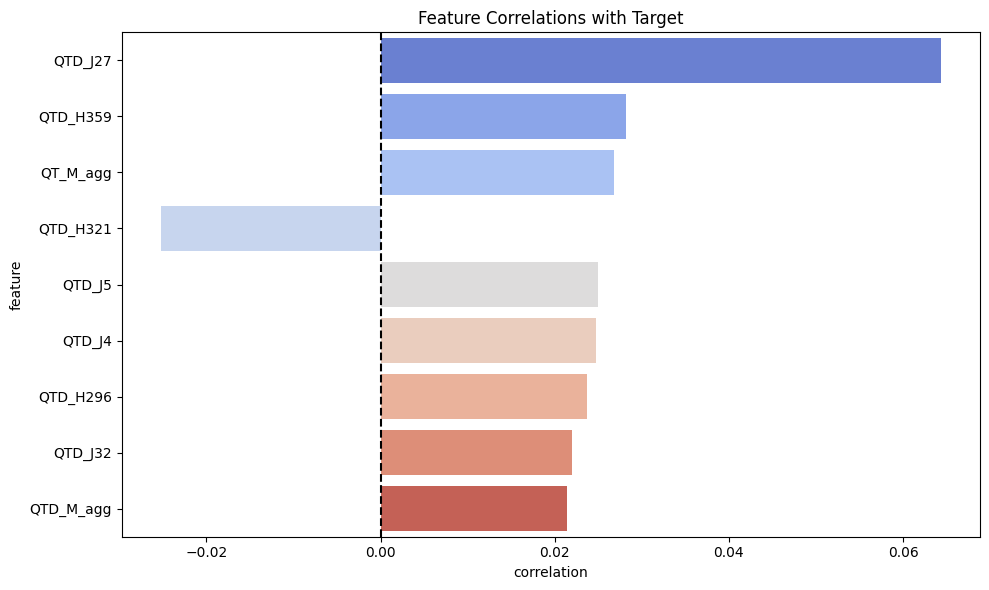

In [36]:
top_corrs = plot_feature_correlations(final_df, 'TARGET')